In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import pandas as pd
import os
import time

In [2]:
!nvidia-smi

Fri Nov 10 16:04:38 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:17:00.0 Off |                    0 |
| N/A   26C    P0              44W / 250W |   8954MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
# Check the number of GPUs available
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

Number of GPUs available: 1


# read data

In [4]:
 # import npy file
input_data = np.load('/scratch/amath12/new_input_data_pickled.pkl', allow_pickle=True)
output_data= np.load('/scratch/amath12/new_output_data_pickled.pkl', allow_pickle=True)

print(input_data.shape, output_data.shape)

(1360, 256, 256) (1360, 256, 256)


In [5]:
# unsqueeze the data
input_data = np.expand_dims(input_data, axis=1)
output_data = np.expand_dims(output_data, axis=1)   

print(input_data.shape, output_data.shape)

(1360, 1, 256, 256) (1360, 1, 256, 256)


In [6]:
# make dataloader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

# convert to tensor
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# create dataloader
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)



In [7]:


def downsample(input_channels, output_channels, kernel_size, apply_batchnorm=True, dropout_prob=0.0, weight_mean=0, weight_sd=0.02):
    layers = [nn.Conv2d(input_channels, output_channels, kernel_size, stride=2, padding=1, bias=False)]
    
    # Initialize the weights with mean and standard deviation
    nn.init.normal_(layers[0].weight, mean=weight_mean, std=weight_sd)
    
    if apply_batchnorm:
        layers.append(nn.BatchNorm2d(output_channels))
    layers.append(nn.LeakyReLU(0.2))
    
    if dropout_prob > 0.0:
        layers.append(nn.Dropout(dropout_prob))
    
    return nn.Sequential(*layers)

def upsample(input_channels, output_channels, kernel_size, apply_batchnorm=True, dropout_prob=0.0, weight_mean=0, weight_sd=0.02):
    layers = [nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=2, padding=1, bias=False)]
    
    # Initialize the weights with mean and standard deviation
    nn.init.normal_(layers[0].weight, mean=weight_mean, std=weight_sd)
    
    if apply_batchnorm:
        layers.append(nn.BatchNorm2d(output_channels))
    layers.append(nn.ReLU())
    
    if dropout_prob > 0.0:
        layers.append(nn.Dropout(dropout_prob))
    
    return nn.Sequential(*layers)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Define the downsample layers
        self.conv_layers = nn.ModuleList([
            downsample(1, 64, 4),
            downsample(64, 128, 4),
            downsample(128, 256, 4),
            downsample(256, 512, 4),
            downsample(512, 512, 4),
            downsample(512, 512, 4),
            downsample(512, 512, 4),
            downsample(512, 512, 4)
        ])

        # Define the upsample layers
        self.up_layers = nn.ModuleList([
            upsample(512, 512, 4),
            upsample(1024, 512, 4),
            upsample(1024, 512, 4),
            upsample(1024, 512, 4),
            upsample(1024, 256, 4),
            upsample(512, 128, 4),
            upsample(256, 64, 4)
        ])

        # Final convolutional layer for generating the output
        self.last = nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1)

    def forward(self, x):
        # Downsampling through the model
        skips = []
        for layer in self.conv_layers:
            x = layer(x)
            skips.append(x)
        
        skips = skips[:-1]

        # Upsampling and establishing skip connections
        for layer, skip in zip(self.up_layers, reversed(skips)):
            x = layer(x)
            x = torch.cat([x, skip], dim=1)

        x = self.last(x)
        return x

# Instantiate the Generator model
generator = Generator()

In [8]:

# Define the loss function
criterion = nn.MSELoss()
#criterion = nn.L1Loss()


# Define the optimizer
optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4)

In [9]:
losses=[]

In [10]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the appropriate device

generator.to(device)

cuda


Generator(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2

In [11]:
# Define the number of epochs
# Record the start time
start_time = time.time()
num_epochs = 300

mse_loss = torch.nn.MSELoss()

# make training loop ( with data loader)

iter=0
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()

        # Predict
        output = generator(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Log losses
        losses.append(loss.item())

        if iter % 100 == 0:
            print(f"Epoch: {epoch}, loss: {loss.item()}")
            
            generator.eval()  # Set the generator to evaluation mode
            with torch.no_grad():  # No gradients needed for evaluation
                test_mse = 0.0
                test_samples = 0
                
                for input_image, target in test_loader:
                    # Transfer to GPU
                    input_image = input_image.to(device)
                    target = target.to(device)
                    
                    # Generate the output using the generator for the current batch
                    gen_output = generator(input_image)
                    
                    # Calculate and accumulate MSE loss
                    test_mse += mse_loss(gen_output, target).item() * target.size(0)
                    test_samples += target.size(0)
                
                # Compute the average MSE over the test set
                test_mse /= test_samples
            
            print(f'Epoch {epoch}: Average MSE on Test Set: {test_mse}')
            generator.train()  # Set the generator back to training mode
            
        iter += 1


Epoch: 0, loss: 3.921088457107544
Epoch 0: Average MSE on Test Set: 0.744505903300117
Epoch: 2, loss: 0.02169566974043846
Epoch 2: Average MSE on Test Set: 0.22910900852259466
Epoch: 5, loss: 0.012640286237001419
Epoch 5: Average MSE on Test Set: 0.013571542632930419
Epoch: 8, loss: 0.00737097579985857
Epoch 8: Average MSE on Test Set: 0.008994124008013922
Epoch: 11, loss: 0.00728991162031889
Epoch 11: Average MSE on Test Set: 0.012938718256704947
Epoch: 14, loss: 0.005661037750542164
Epoch 14: Average MSE on Test Set: 0.0060901209602461145
Epoch: 17, loss: 0.009872396476566792
Epoch 17: Average MSE on Test Set: 0.005217735162552665
Epoch: 20, loss: 0.009219331666827202
Epoch 20: Average MSE on Test Set: 0.013485507710891612
Epoch: 23, loss: 0.006056870333850384
Epoch 23: Average MSE on Test Set: 0.005054109866785652
Epoch: 26, loss: 0.006456790957599878
Epoch 26: Average MSE on Test Set: 0.0034424974309170946
Epoch: 29, loss: 0.004838872700929642
Epoch 29: Average MSE on Test Set: 0.0

In [12]:
end_time = time.time()
training_time = end_time - start_time
# Print the training time
print(f"Training Time for UNet: {training_time} seconds")

Training Time for UNet: 375.291784286499 seconds


In [13]:
PATH = 'pytorch_generator_only.pth'
torch.save(generator.state_dict(), PATH)
#torch.save(generator, PATH)

In [14]:
def generate_images( test_input, tar, prediction):
  plt.figure(figsize=(15, 15))
  display_list = [test_input, tar, prediction]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5, cmap='jet')
    plt.axis('off')
  plt.show()

# def generate_images(test_input, tar, prediction):
#   '''
#   ensures the target and predicted are on the same color scale
#   '''

#   plt.figure(figsize=(15, 15))

#   display_list = [test_input[0], tar[0], prediction[0]]
#   title = ['Input Image', 'Ground Truth', 'Predicted Image']

#   global_min = min([np.min(img) for img in [tar[0], prediction[0]]])
#   global_max = max([np.max(img) for img in [tar[0], prediction[0]]])

#   plt.subplot(1, 3, 1)
#   plt.title(title[0])
#   plt.imshow(test_input, cmap='jet')
#   plt.axis('off')
#   plt.subplot(1, 3, 2)
#   plt.title(title[1])
#   plt.imshow(tar, cmap='jet', vmin=global_min, vmax=global_max)
#   plt.axis('off')
#   plt.subplot(1, 3, 3)
#   plt.title(title[2])
#   plt.imshow(prediction, cmap='jet', vmin=global_min, vmax=global_max)
#   plt.axis('off')  
#   # for i in range(3):
#   #   plt.subplot(1, 3, i+1)
#   #   plt.title(title[i])
#   #   # Getting the pixel values in the [0, 1] range to plot.
#   #   #plt.imshow(display_list[i] * 0.5 + 0.5, cmap='jet')
#   #   plt.imshow(display_list[i], cmap='jet', vmin=global_min, vmax=global_max)
#   #   #plt.colorbar()
#   #   plt.axis('off')
#   plt.show()

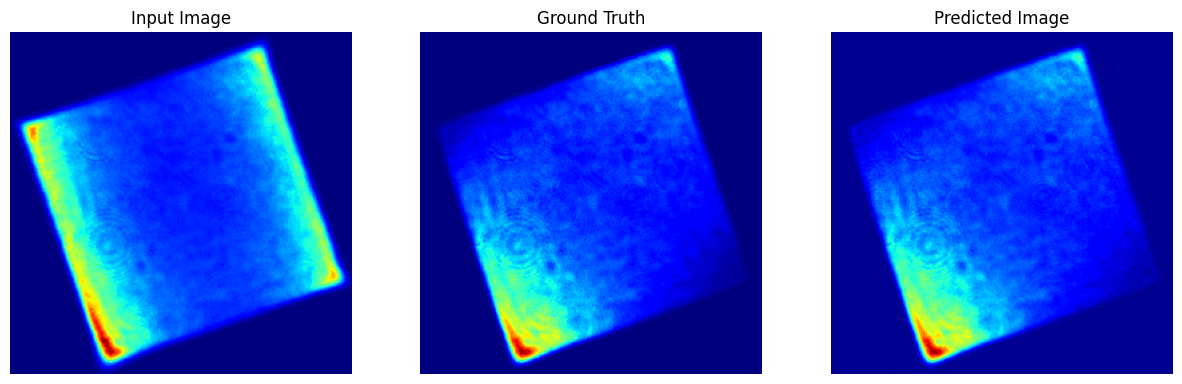

Generator(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2

In [15]:
image_index = 40

# Switch the generator to evaluation mode
generator.eval()

# # Get a batch of test inputs and targets
# test_input, tar = next(iter(test_loader))

# # Transfer them to the same device as your model
# test_input, tar = test_input.to(device), tar.to(device)

test_input = X_test[image_index].unsqueeze(1).to(device)

# Generate predictions
with torch.no_grad():  # No gradients required for generating predictions
    prediction = generator(test_input)

# # Move tensors back to CPU for visualization if they are on GPU
# test_input, tar, prediction = test_input.cpu(), tar.cpu(), prediction.cpu()

# Assuming the images are single-channel (grayscale) and are currently in [C, H, W] format,
# you need to use `squeeze()` to remove the channel dimension if C=1 for plotting
# test_input = test_input.squeeze(1)
# tar = tar.squeeze(1)
test_input = X_test[image_index].squeeze(1)
tar = y_test[image_index].squeeze(1)
prediction = prediction.squeeze(1)

# Use the utility function to display the images
# If images are in tensors, convert them to numpy for matplotlib
generate_images(test_input[0].numpy(), tar[0].numpy(), prediction[0].cpu().numpy())

# Switch the generator back to training mode if you have more training to do
generator.train()

In [16]:
# release GPU memory
torch.cuda.empty_cache()

In [17]:
# convert X_test, y_test,output_test to numpy
X_test_nmp = X_test.cpu().detach().numpy()
y_test_nmp = y_test.cpu().detach().numpy()

# generate images
generator.eval()
output_test = generator(X_test.to(device))
output_test_nmp = output_test.cpu().detach().numpy()

# delete gpu cache
del output_test
torch.cuda.empty_cache()

In [18]:
X_test_nmp.shape

(272, 1, 256, 256)

In [19]:
output_test_nmp.shape

(272, 1, 256, 256)

In [20]:
# train loader without shuffle
train_loader_1 = DataLoader(train_data, batch_size=batch_size, shuffle=False)

X_train_nmp = X_train.cpu().detach().numpy()
y_train_nmp = y_train.cpu().detach().numpy()

output_train=[]

# generate images
generator.eval()

for (data, target) in train_loader_1:
    data, target = data.to(device), target.to(device)
    output = generator(data)
    output_train.append(output.cpu().detach().numpy())


In [21]:
# concatenate the output_train
output_train = np.array(output_train)
output_train_nmp = np.concatenate(output_train, axis=0)

In [22]:
# squeeze first dimension
output_train_nmp = np.squeeze(output_train_nmp, axis=1)
X_train_nmp = np.squeeze(X_train_nmp, axis=1)
y_train_nmp = np.squeeze(y_train_nmp, axis=1)

output_test_nmp = np.squeeze(output_test_nmp, axis=1)
X_test_nmp = np.squeeze(X_test_nmp, axis=1)
y_test_nmp = np.squeeze(y_test_nmp, axis=1)

In [23]:
# evaluate mse, rmse on test and   train data

from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error

# calculate mse
mse_test=[]

for i in range(output_test_nmp.shape[0]):
    mse_test.append(mean_squared_error(y_test_nmp[i], output_test_nmp[i]))

print('test mse', np.mean(mse_test))

mse_train=[]

for i in range(output_train_nmp.shape[0]):
    mse_train.append(mean_squared_error(y_train_nmp[i], output_train_nmp[i]))

print('train mse', np.mean(mse_train))

test mse 0.0004140475
train mse 0.00038463424


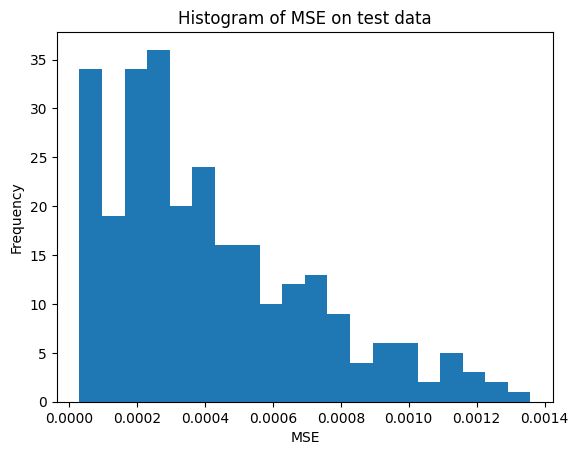

In [24]:
# histogram of mse_test
plt.hist(mse_test, bins=20)
plt.title('Histogram of MSE on test data')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()

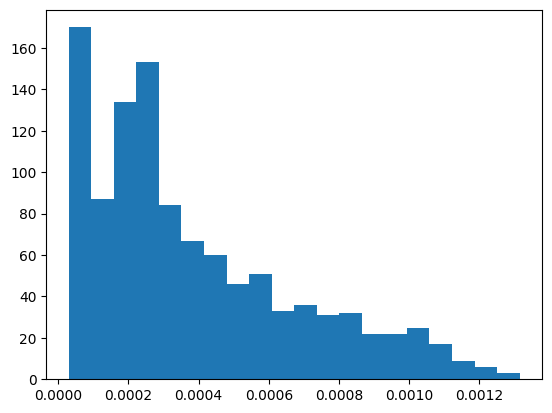

In [25]:
plt.hist(mse_train, bins=20)
plt.show()

In [26]:
# define MAPE

def mape(output,truth):
    # sreshape to one dimension
    output=np.reshape(output, (output.shape[0]*output.shape[1]))
    truth=np.reshape(truth, (truth.shape[0]*truth.shape[1]))

    mape_values=[]
    for i in range(output.shape[0]):
        if truth[i]!=0:
            mape_values.append(np.abs((output[i]-truth[i])/truth[i]))

    return np.mean(mape_values)
        

In [27]:
# mape distribution 

def mape_distribution(output,truth):
    
    mape_distribution=np.zeros((output.shape[0], output.shape[1]))
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if truth[i,j]!=0:
                mape_distribution[i,j]=np.abs((output[i,j]-truth[i,j])/truth[i,j])
            else:
                mape_distribution[i,j]=0

    #print(mape_distribution.shape)

    return mape_distribution


In [28]:
all_mapes_distributions=[]

for i in range(output_test_nmp.shape[0]):
    all_mapes_distributions.append(mape_distribution(output_test_nmp[i], y_test_nmp[i]))

all_mapes_distributions=np.array(all_mapes_distributions)

In [29]:
all_mapes_distributions.shape

(272, 256, 256)

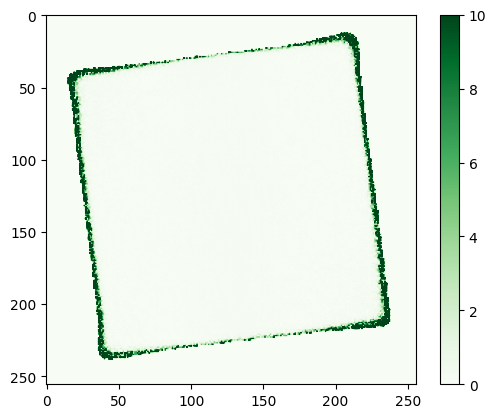

In [30]:
# plot all mape distributions
for i in range(all_mapes_distributions.shape[0]):
    plt.imshow(all_mapes_distributions[i], cmap='Greens')
    # range of colorbar is 0 to 10
    plt.clim(0, 10)
    plt.colorbar()
    plt.show()
    break

In [31]:
def mse_distribution(output,truth):
    
    mse_distribution=np.zeros((output.shape[0], output.shape[1]))
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            mse_distribution[i,j]=np.square(output[i,j]-truth[i,j])

    #print(mse_distribution.shape)

    return mse_distribution

In [32]:
all_mse_distributions=[]
for i in range(output_test_nmp.shape[0]):
    all_mse_distributions.append(mse_distribution(output_test_nmp[i], y_test_nmp[i]))
    

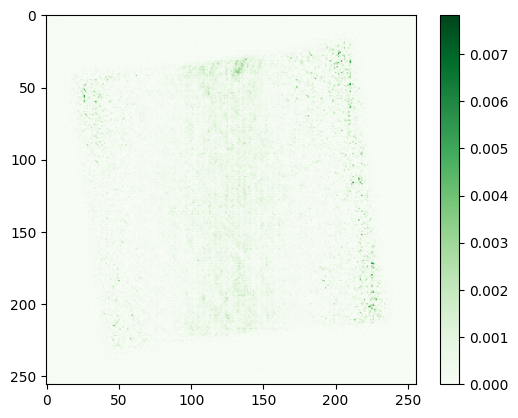

In [33]:
# plot all mse distributions

all_mse_distributions=np.array(all_mse_distributions)
for i in range(all_mse_distributions.shape[0]):
    plt.imshow(all_mse_distributions[i], cmap='Greens')
    plt.colorbar()
    plt.show()
    break

In [34]:
# create 100 samle images from test data

lol=torch.rand(100, 1, 256, 256, device='cuda')

import time

start=time.time()
generator.eval()
lol_test = generator(lol)
lol_test_nmp = lol_test.cpu().detach().numpy()
end=time.time()

In [35]:
print('time taken to generate 100 images', end-start)

time taken to generate 100 images 0.06126713752746582
